# **NLP Project**

In this project, it will be used the deep learning model from the paper [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf), by replicating the paper [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071). */Cheers for the authors. Outstanding job!/*

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In this way, we shall create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

I'd like to thank **Mr. Daniel Bourke** for helping with this project.

## Loading Libraries 

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

import random
import os
import time
import help_me

## Confirm Access to GPU

In [1]:
# !nvidia-smi -L

## Get Data

Getting the data from the [Github repository](https://github.com/Franck-Dernoncourt/pubmed-rct.git).

In [3]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
for dirpath, dirnames, filenames in os.walk('pubmed-rct/'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 5 directories and 1 files in 'pubmed-rct/'.
There are 5 directories and 5 files in 'pubmed-rct/.git'.
There are 0 directories and 13 files in 'pubmed-rct/.git\hooks'.
There are 0 directories and 1 files in 'pubmed-rct/.git\info'.
There are 1 directories and 1 files in 'pubmed-rct/.git\logs'.
There are 2 directories and 0 files in 'pubmed-rct/.git\logs\refs'.
There are 0 directories and 1 files in 'pubmed-rct/.git\logs\refs\heads'.
There are 1 directories and 0 files in 'pubmed-rct/.git\logs\refs\remotes'.
There are 0 directories and 1 files in 'pubmed-rct/.git\logs\refs\remotes\origin'.
There are 2 directories and 0 files in 'pubmed-rct/.git\objects'.
There are 0 directories and 0 files in 'pubmed-rct/.git\objects\info'.
There are 0 directories and 2 files in 'pubmed-rct/.git\objects\pack'.
There are 3 directories and 0 files in 'pubmed-rct/.git\refs'.
There are 0 directories and 1 files in 'pubmed-rct/.git\refs\heads'.
There are 1 directories and 0 files in 'pubmed-rct/.git\

In [4]:
# Checking the files in the PubMed_20K dataset
for _, _, filename in os.walk('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'):
    print(f"Files: {filename}")

Files: ['dev.txt', 'test.txt', 'train.txt']


In [5]:
# Starting the experiments using the 20k dataset with numbers replaced by '@ sign
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data

Writing a function to read in all of the lines of a target text file.

In [7]:
# Create a funtion to read the lines of the document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of the text as a list.
    
    Args:
        filename: a string containing the target filepath
        
    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, 'r') as f:
        return f.readlines()    

In [8]:
# Reading the training lines
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

> Writing a function which turns each of our datasets into a dictionary format.

In [9]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.
    
    Takes in filename, reads its contents and sorts through each line, extracting
    things like the target label, the text of the sentence, how many sentences are
    in the current abstract and what sentence number the target line is.
    """
    
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = '' # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts
    
    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # check to see if the line is and ID line
            abstract_id = line
            abstract_lines = '' # reset the abstract string if the line is an ID line
            
        elif line.isspace(): # check to see if line is a new line or empty space
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            
            # iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create and empty dictionary for each line
                target_text_split = abstract_line.split('\t') #split target label from text
                line_data['target'] = target_text_split[0] #get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lower it
                line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract
                line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list
                
        # if the above conditions are not fulfilled, the line contains a labelled sentence
        else:
            abstract_lines += line
    
    return abstract_samples

In [10]:
%%time 

# get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt') # dev is another name for val
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
Wall time: 559 ms


In [11]:
# check the first abstract of the training data
train_samples[:3]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11}]

Data in Dictionary format. Let's turn it into DataFrame

In [12]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

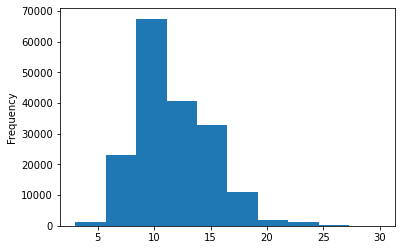

In [14]:
# Length of differente lines
train_df.total_lines.plot.hist()

### Get a list of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# First 8 training sentences
train_sentences[:8]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Labelling Target 

In [17]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False) # tensorflow is incompatible with sparse matrix datatype
train_labels_ohe = ohe.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_ohe = ohe.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_ohe = ohe.transform(test_df['target'].to_numpy().reshape(-1,1))

# checking training labels
train_labels_ohe

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encode

In [18]:
# Extract labels ('target') and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_enc = label_encoder.transform(val_df['target'].to_numpy())
test_labels_enc = label_encoder.transform(test_df['target'].to_numpy())

# checking training labels
train_labels_enc

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Getting class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a Series of Model Experiments

Trying a few different models and watching their behaviour.

> Tip: [Chris Albon](https://chrisalbon.com/)

## Model 0: Getting a baseline 

In [20]:
# TF-IDF multinomial Naive Bayes model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creating a pipeline
## usually multinomialnb accepts label encoding
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_enc)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences, y=val_labels_enc)

0.7218323844829869

In [22]:
# Making Predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
# Getting baseline results
baseline_results = help_me.calculate_results(val_labels_enc, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing the data (text) for deep sequence models

`vectorization` and `embedding_layers`

In [27]:
# measuring sentence length
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len # average sentenc length

26.338269273494777

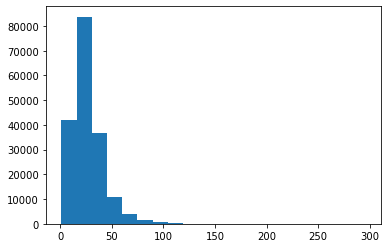

In [29]:
# Evualitng distribution of sentences' lengths
plt.hist(sent_len, bins=20);

In [32]:
# where do the 95% of the lengths reaches?
output_seq_len = int(np.percentile(sent_len, 95))

# max sentence
max_sent = max(sent_len)
print(f'95% of the sentences has until {output_seq_len} tokens - Max length: {max_sent}')

95% of the sentences has until 55 tokens - Max length: 296


### Text Vectorizer Layer

In [33]:
# according to the paper, there are ~68k tokens
max_tokens = 68000

# Creating vectorizer
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=55)

# adapting text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [42]:
# test out text vectorizer
rand_sentence = random.choice(train_sentences)
print(f'Text:\n{rand_sentence}')
print(f'\nLength of the Text: {len(rand_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([rand_sentence])}')

Text:
in the remaining period , the proportion was greater in the toric iol group .

Length of the Text: 15

Vectorized text: [[   5    2 2165  173    2  443   10  182    5    2 4134 1553   13    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [35]:
# checking more informations on training data
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocabulary: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocabulary: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}')

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# general configurations of the vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Creating Text Embedding

In [45]:
# creating token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), output_dim=128,
                              mask_zero=True, name='token_embedding')

# show example embedding
print(f'Sentence before vectorization:\n{rand_sentence}\n')
vec_sentence = text_vectorizer(rand_sentence)
print(f'Sentence after vectorization (before embedding):\n{vec_sentence}')
embed_sentence = token_embed(vec_sentence)
print(f'Sentence after embedding: {embed_sentence}\n')
print(f'Embed sentence shape: {np.expand_dims(embed_sentence,axis=0).shape}')

Sentence before vectorization:
in the remaining period , the proportion was greater in the toric iol group .

Sentence after vectorization (before embedding):
[   5    2 2165  173    2  443   10  182    5    2 4134 1553   13    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
Sentence after embedding: [[ 0.02422137 -0.02420558  0.01866012 ...  0.04489921  0.04728759
  -0.0229434 ]
 [ 0.01384857 -0.01301173 -0.00712528 ... -0.04676795  0.03243167
   0.02849586]
 [-0.00131835  0.04488683  0.01315096 ... -0.0057499  -0.01110907
   0.01018788]
 ...
 [-0.03282899  0.03668256 -0.00564703 ... -0.01970311 -0.03756158
   0.03742751]
 [-0.03282899  0.03668256 -0.00564703 ... -0.01970311 -0.03756158
   0.03742751]
 [-0.03282899  0.03668256 -0.00564703 ... -0.01970311 -0.03756158
   0.03742751]]

Embed sentence shape: (1, 55, 128)


## Creating Datasets

It's possible to optimize the data loading. One possible method is to turn the data into
`PrefetchDataset`. In this way, we cam prepare the data better. 

Read documentation:
 * [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
 * [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

In [46]:
# turning the data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_ohe))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_ohe))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_ohe))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [47]:
# taking the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(32)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with Token Embeddings

Sequence to be made:
`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`

In [49]:
# Create 1D convolutional model to process sequences

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size = 5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1')

# compile the model
model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [50]:
# get summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325 

In [52]:
# fitting the data (for now only in 30% of the original data)
## train and validate on only 30% of the data
history_1 = model_1.fit(train_dataset, steps_per_epoch=int(0.3*len(train_dataset)), epochs=3,
                       validation_data=val_dataset, validation_steps=int(0.3*len(val_dataset)))

Epoch 1/3
1688/1688 [==============================] - 20s 11ms/step - loss: 0.4689 - accuracy: 0.8351 - val_loss: 0.5915 - val_accuracy: 0.7901
Epoch 2/3
1688/1688 [==============================] - 19s 11ms/step - loss: 0.5788 - accuracy: 0.7930 - val_loss: 0.5369 - val_accuracy: 0.8116
Epoch 3/3
1688/1688 [==============================] - 19s 11ms/step - loss: 0.5397 - accuracy: 0.8080 - val_loss: 0.5366 - val_accuracy: 0.8051


In [53]:
# evaluating on the whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5368 - accuracy: 0.8075


[0.5368258357048035, 0.8075268268585205]

In [55]:
# making predictions (the model outputs probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[6.90707445e-01, 9.57161412e-02, 9.29798111e-02, 9.19058695e-02,
        2.86906604e-02],
       [6.71646893e-01, 1.92644969e-01, 1.56376474e-02, 1.06196553e-01,
        1.38739049e-02],
       [3.94774199e-01, 5.61188255e-03, 3.92274279e-03, 5.95585942e-01,
        1.05231724e-04],
       ...,
       [4.96507573e-06, 4.99794915e-05, 1.69747812e-03, 6.14041255e-06,
        9.98241425e-01],
       [1.31124273e-01, 4.06432450e-01, 2.03278974e-01, 3.48502360e-02,
        2.24314079e-01],
       [6.97216690e-02, 8.90669227e-01, 3.22739817e-02, 7.11093133e-04,
        6.62398711e-03]], dtype=float32)

In [56]:
# converting pred probabilities to classes
model_1_pred = tf.argmax(model_1_pred_probs, axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [57]:
# model_1 results
model_1_results = help_me.calculate_results(y_true=val_labels_enc, y_pred=model_1_pred)
model_1_results

{'accuracy': 80.75268105388588,
 'precision': 0.813204630252371,
 'recall': 0.8075268105388588,
 'f1': 0.8016843900589935}

## Model 2: Feature Extraction w/ Pretrained Token Embeddings

Using a pretrained Universal Sequence Encoder (USE) to initialize the token embeddings (pretrained embedding).

In [59]:
# download pretrained tensorflow hub USE
tf_hub_emb_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 name='universal_sentence_encoder')

In [61]:
# testing out the embedding on a random sentence
print(f'Random Sentence:\n {rand_sentence}')
embed_seq = tf_hub_emb_layer([rand_sentence])
print(f'Sentence after embedding: {embed_seq[0][:30]} (truncated output to 30).')
print(f'Length of sentence embedding: {len(embed_seq[0])}')

Random Sentence:
 in the remaining period , the proportion was greater in the toric iol group .
Sentence after embedding: [-0.06584997  0.06050936  0.04120971  0.01099056 -0.0040519  -0.0474313
  0.0580865  -0.03127831 -0.03082419  0.08174539  0.02948102  0.03042848
  0.0423879   0.04555092  0.01169337  0.0375018  -0.00931669 -0.05102049
  0.06505606  0.04992852 -0.07943188  0.01194951 -0.06041338 -0.06012925
  0.06205672  0.05446972  0.03849085  0.0652323  -0.01158352  0.05260089] (truncated output to 30).
Length of sentence embedding: 512


### Building and Fitting the Model